In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm.notebook import tqdm as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale

# Pytorch' NN

## Linear regression with one variable 

In [2]:
data = np.loadtxt('ex1data2.txt', delimiter=',')
size, bedrooms, y = data[:,0], data[:,1], data[:,2]
features = data[:,:2]
N = 2
# M = 97
M = len(size)
output_size = 1
M

47

### Plotting de data

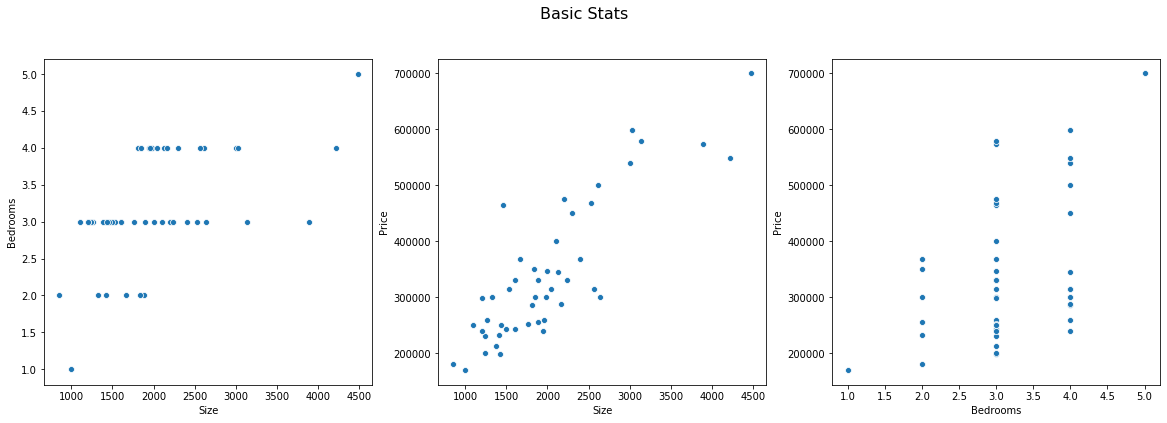

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Basic Stats', fontsize=16, y=1)

sns.scatterplot(x=size, y=bedrooms, ax=ax1)
ax1.set_xlabel('Size')
ax1.set_ylabel('Bedrooms')

sns.scatterplot(x=size, y=y, ax=ax2)
ax2.set_xlabel('Size')
ax2.set_ylabel('Price')

sns.scatterplot(x=bedrooms, y=y, ax=ax3)
ax3.set_xlabel('Bedrooms')
ax3.set_ylabel('Price')

plt.show()

In [4]:
features = scale(features)

In [5]:
features

array([[ 1.31415422e-01, -2.26093368e-01],
       [-5.09640698e-01, -2.26093368e-01],
       [ 5.07908699e-01, -2.26093368e-01],
       [-7.43677059e-01, -1.55439190e+00],
       [ 1.27107075e+00,  1.10220517e+00],
       [-1.99450507e-02,  1.10220517e+00],
       [-5.93588523e-01, -2.26093368e-01],
       [-7.29685755e-01, -2.26093368e-01],
       [-7.89466782e-01, -2.26093368e-01],
       [-6.44465993e-01, -2.26093368e-01],
       [-7.71822042e-02,  1.10220517e+00],
       [-8.65999486e-04, -2.26093368e-01],
       [-1.40779041e-01, -2.26093368e-01],
       [ 3.15099326e+00,  2.43050370e+00],
       [-9.31923697e-01, -2.26093368e-01],
       [ 3.80715024e-01,  1.10220517e+00],
       [-8.65782986e-01, -1.55439190e+00],
       [-9.72625673e-01, -2.26093368e-01],
       [ 7.73743478e-01,  1.10220517e+00],
       [ 1.31050078e+00,  1.10220517e+00],
       [-2.97227261e-01, -2.26093368e-01],
       [-1.43322915e-01, -1.55439190e+00],
       [-5.04552951e-01, -2.26093368e-01],
       [-4.

In [6]:
size

array([2104., 1600., 2400., 1416., 3000., 1985., 1534., 1427., 1380.,
       1494., 1940., 2000., 1890., 4478., 1268., 2300., 1320., 1236.,
       2609., 3031., 1767., 1888., 1604., 1962., 3890., 1100., 1458.,
       2526., 2200., 2637., 1839., 1000., 2040., 3137., 1811., 1437.,
       1239., 2132., 4215., 2162., 1664., 2238., 2567., 1200.,  852.,
       1852., 1203.])

### NN Model Class

In [7]:
torch.set_default_dtype(torch.double)

In [8]:
hidden_size = 1

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(D_in, D_out)
        
    def forward(self, x):
        preds = self.fc1(x)
        return preds

### Training the net

In [10]:
model = NeuralNetwork(N, hidden_size, 1)
optimizer = optim.SGD(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss(reduction='sum')

In [11]:
x_train, x_test, y_train, y_test = train_test_split(features, y, test_size = .2, random_state = 0)
len(x_train), len(x_test)

(37, 10)

In [12]:
x_train_tensor = torch.reshape(torch.tensor(x_train), (len(x_train), N))
y_train_tensor = torch.reshape(torch.tensor(y_train), (len(y_train), 1))

x_test_tensor = torch.reshape(torch.tensor(x_test), (len(x_test), N))
y_test_tensor = torch.reshape(torch.tensor(y_test), (len(y_test), 1))

x_train_tensor.shape, y_train_tensor.shape

(torch.Size([37, 2]), torch.Size([37, 1]))

In [13]:
epochs = 1500
losses = []
for i in tqdm(range(epochs)):
    y_pred = model(x_train_tensor)
    loss = loss_fn(y_pred, y_train_tensor)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [14]:
y_train_tensor[:15], y_pred[:15]

(tensor([[469000.],
         [314900.],
         [299900.],
         [299000.],
         [369000.],
         [299900.],
         [464500.],
         [449900.],
         [249900.],
         [299900.],
         [368500.],
         [252900.],
         [329900.],
         [212000.],
         [699900.]]), tensor([[402996.3514],
         [341611.9943],
         [416880.4994],
         [237137.0709],
         [387235.9673],
         [318096.5005],
         [269408.3336],
         [374133.4218],
         [224628.8295],
         [252741.2646],
         [295769.6149],
         [308058.7994],
         [366972.6163],
         [259651.9053],
         [645968.6147]], grad_fn=<SliceBackward>))

### Validating the net

In [15]:
with torch.no_grad():
    y_train_pred = model(x_train_tensor)
    y_test_pred = model(x_test_tensor)

In [16]:
y_train_pred = np.squeeze(y_train_pred.detach().numpy())
score_train = r2_score(y_train, y_train_pred)
print(f'Score in training: {score_train}')

Score in training: 0.7368882489744906


In [17]:
y_test_pred = np.squeeze(y_test_pred.detach().numpy())
score_test = r2_score(y_test, y_test_pred)
print(f'Score in training: {score_test}')

Score in training: 0.6721521292832836


### Plotting results

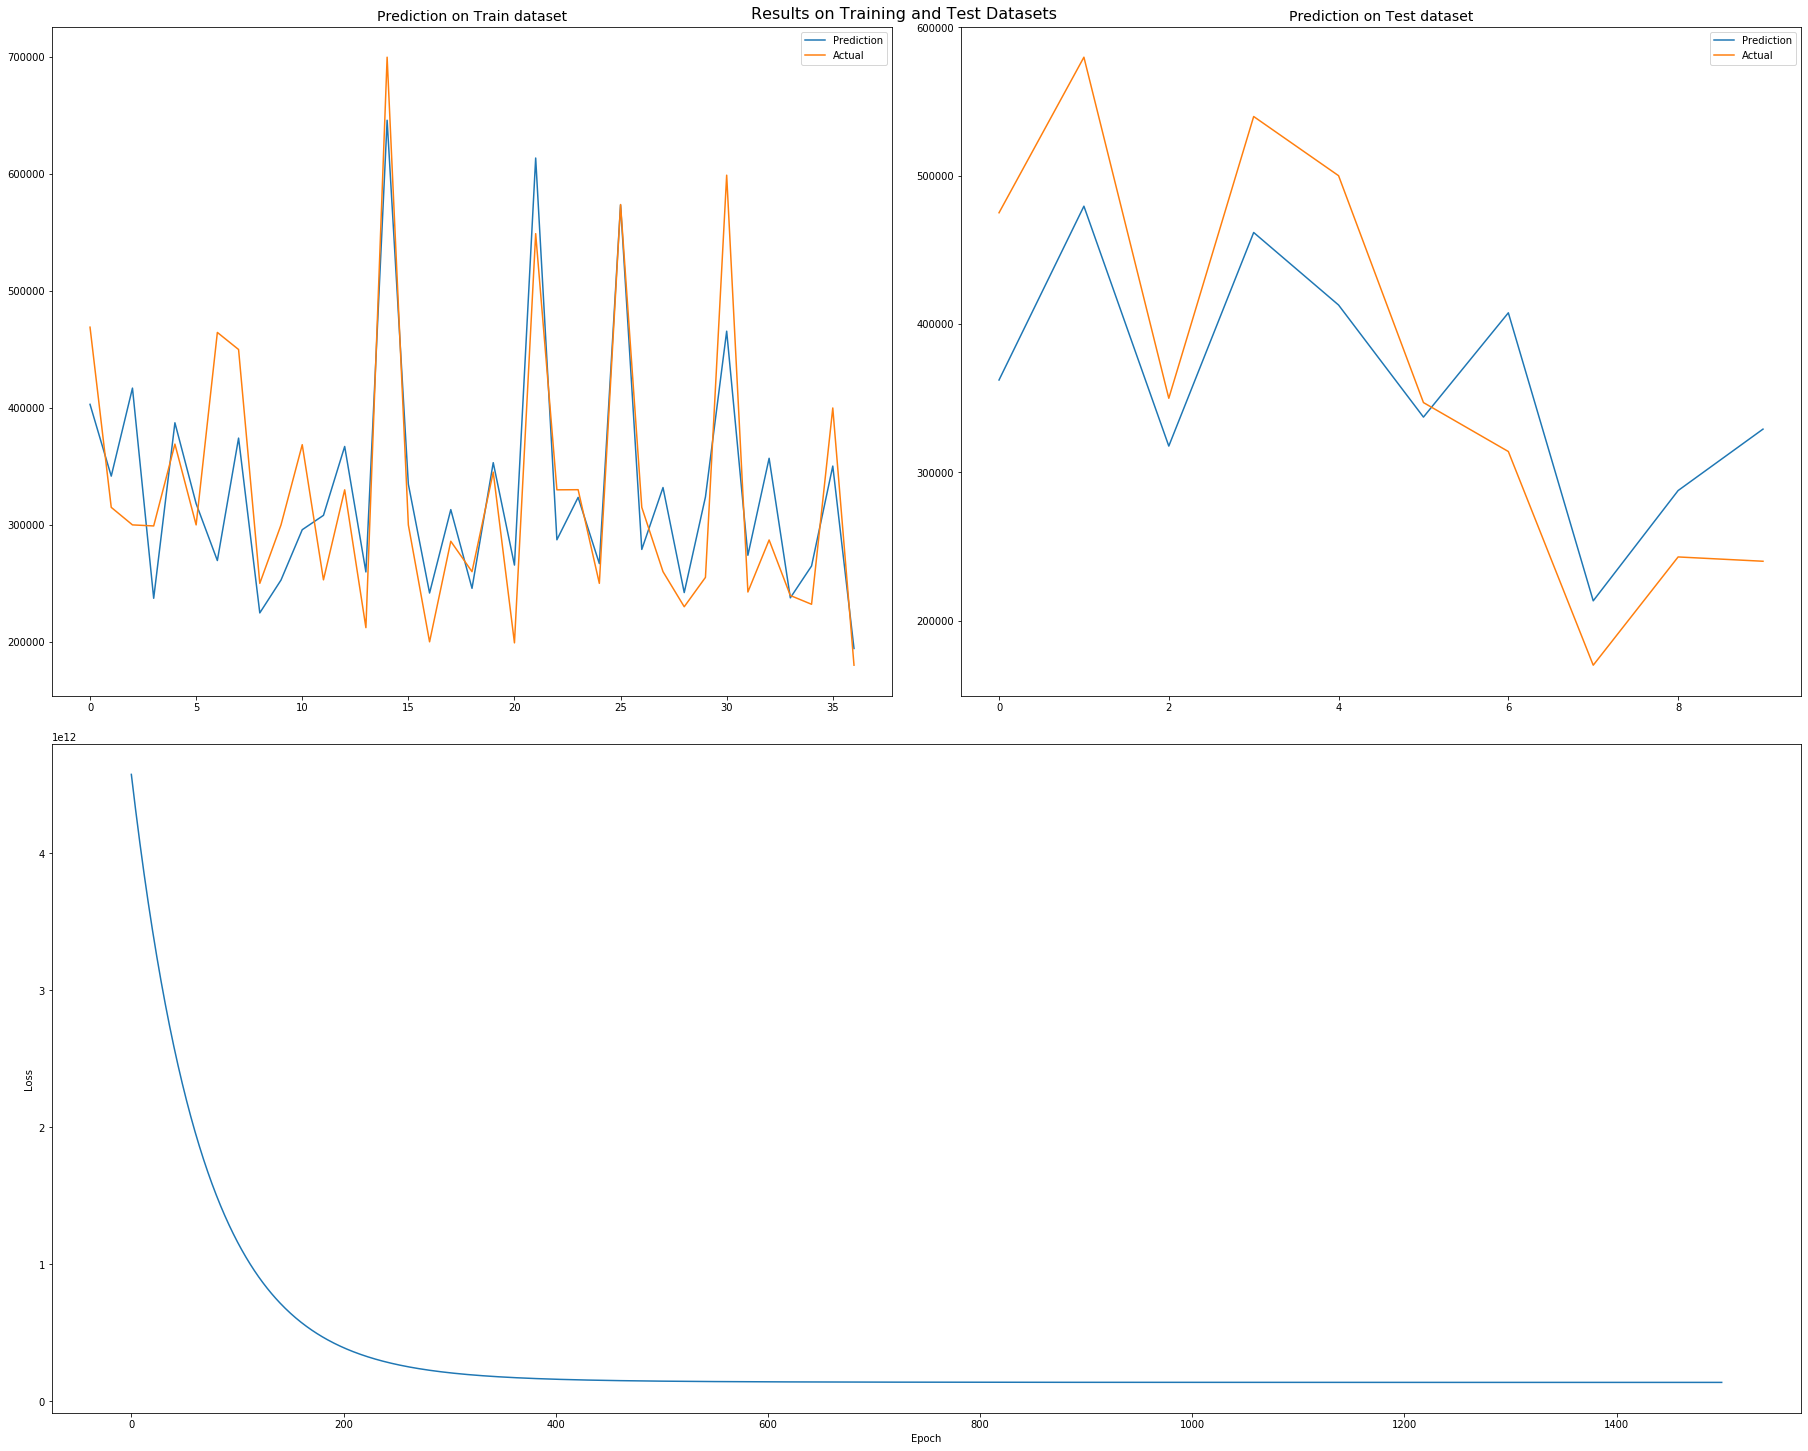

In [18]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(3, 2, figsize=(25, 15))
fig = plt.figure(constrained_layout=True, figsize=(25, 20))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, :])

fig.suptitle('Results on Training and Test Datasets', fontsize=16, y=1)

sns.lineplot(y=y_train_pred, x=range(len(y_train_pred)), ax=ax1, label='Prediction')
sns.lineplot(y=y_train, x=range(len(y_train)), ax=ax1, label='Actual')
ax1.set_title('Prediction on Train dataset', fontsize=14)

sns.lineplot(y=y_test_pred, x=range(len(y_test_pred)), ax=ax2, label='Prediction')
sns.lineplot(y=y_test, x=range(len(y_test)), ax=ax2, label='Actual')
ax2.set_title('Prediction on Test dataset', fontsize=14)

sns.lineplot(y=losses, x=range(len(losses)), ax=ax3)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')

plt.show()